## PSF size from adaptive moments: trace radius and determinant radius 

### Following:  LSST DM Stack Image Quality Walkthrough 

https://github.com/LSSTScienceCollaborations/StackClub/blob/a08df1992e5100fdc01d88f3f5a979e5b96841c3/Validation/image_quality_demo.ipynb


In [1]:
# general python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.collections import PatchCollection
import itertools
%matplotlib inline

# Rubin TAP service utilities
import lsst.geom as geom
import lsst.afw.display as afwDisplay  # for image visualization
import lsst.afw.table as afwTable
from lsst.daf.butler import Butler # access to LSST data products
import lsst.daf.base as dafBase
afwDisplay.setDefaultBackend('matplotlib')
from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius

from lsst.afw.cameraGeom import utils as cgUtils
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms, ampPixelToCcdPixel

from lsst.afw.cameraGeom import FIELD_ANGLE, FOCAL_PLANE, PIXELS
import lsst.afw.cameraGeom as cameraGeom
import lsst.afw.geom as afwGeom

import warnings
from astropy.units import UnitsWarning
warnings.simplefilter("ignore", category=UnitsWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
#repo = 's3://butler-us-central1-dp01'
#collection = '2.2i/runs/DP0.2'
#butler = Butler(repo, collections=collection)

repo = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(repo, collections=collection)

In [3]:
def PSF_diagnostics(visit, detector, band): 
    dataId={'band':band,'visit':visit,'detector':detector}  
    calexp = butler.get('calexp', **dataId)
    src = butler.get('src', **dataId)

    psf = calexp.getPsf()
    shape = psf.computeShape()
    x_array = np.arange(0, calexp.getDimensions()[0]+1, 200)
    y_array = np.arange(0, calexp.getDimensions()[1]+1, 200)
    xx, yy = np.meshgrid(x_array, y_array)

    size = [] # trace radius
    det_radius = []
    i_xx, i_yy, i_xy = [] , [] , []
    for x, y in zip(xx.flatten(), yy.flatten()):
        point = geom.Point2D(x, y)
        shape = psf.computeShape(point)
        size.append(shape.getTraceRadius())
        det_radius.append(shape.getDeterminantRadius()) 
        i_xx.append(shape.getIxx())
        i_yy.append(shape.getIyy())
        i_xy.append(shape.getIxy())
    size = np.reshape(size, xx.shape)
    i_xx = np.reshape(i_xx, xx.shape)
    i_yy = np.reshape(i_yy, xx.shape)
    i_xy = np.reshape(i_xy, xx.shape)
    det_radius = np.reshape(det_radius, xx.shape)
    dif_rad = np.abs(size - det_radius)

    e1 = (i_xx - i_yy) / (i_xx + i_yy)
    e2 = (2. * i_xy) / (i_xx + i_yy)
    e = np.sqrt(e1**2 + e2**2)
    theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
    ex = e * np.cos(theta)
    ey = e * np.sin(theta)

    def ellipticity_radii(i_xx, i_yy, i_xy):
        theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
        e1 = (i_xx - i_yy) / (i_xx + i_yy)
        e2 = (2. * i_xy) / (i_xx + i_yy)
        e = np.sqrt(e1**2 + e2**2)
        TraceRad = np.sqrt((i_xx + i_yy) / 2.)
        DetRad = (i_xx * i_yy - i_xy**2)**(1. / 4.)
        return TraceRad, DetRad, e

    def comparison_src_psf(sample):
        output = []
        for i in range(len(sample)):
            point = sample[i].getCentroid()
            shape_psf = psf.computeShape(point)
            i_xx_psf = sample[i]['base_SdssShape_psf_xx']#shape_psf.getIxx()
            i_yy_psf = sample[i]['base_SdssShape_psf_yy']#shape_psf.getIyy()
            i_xy_psf = sample[i]['base_SdssShape_psf_xy']#shape_psf.getIxy()
            TraceRad_psf, DetRad_psf, e_psf = ellipticity_radii(i_xx_psf, i_yy_psf, i_xy_psf)#shape_psf.getTraceRadius()
            #DetRad_psf = shape_psf.getDeterminantRadius()

            i_xx_src = sample[i]['base_SdssShape_xx']
            i_yy_src = sample[i]['base_SdssShape_yy']
            i_xy_src = sample[i]['base_SdssShape_xy']
            e_src = ellipticity_radii(i_xx_src, i_yy_src, i_xy_src)[2]
            TraceRad_src , DetRad_src , e_src= ellipticity_radii(i_xx_src, i_yy_src, i_xy_src)
            #DetRad_src = ellipticity_radii(i_xx_src, i_yy_src, i_xy_src)[1]
            x_point = point[0]
            y_point = point[1]
            mag = -2.5*np.log10(sample[i]['base_CircularApertureFlux_17_0_instFlux'])
    
            output.append([x_point, y_point, TraceRad_psf, DetRad_psf, e_psf, TraceRad_src, DetRad_src, e_src, mag])

        return np.asarray(output)

    #psf_used = src[(src['calib_psf_used'] == True) & (-2.5*np.log10(src['base_CircularApertureFlux_17_0_instFlux']) > -13)]
    #psf_reserved = src[(src['calib_psf_reserved'] == True) & (-2.5*np.log10(src['base_CircularApertureFlux_17_0_instFlux']) > -13)]

    psf_used = src[src['calib_psf_used'] == True]
    psf_reserved = src[src['calib_psf_reserved'] == True]

    
    used = comparison_src_psf(psf_used)
    reserved = comparison_src_psf(psf_reserved)

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    #############  CALEXP  #############
    plt.sca(ax[0,0])  
    display1 = afwDisplay.Display(frame=fig)
    display1.scale('linear', 'zscale')
    display1.mtv(calexp.image)
    display1.show_colorbar(False)
    plt.text(150, 150, band +" band", color = 'y', fontsize=20)
    plt.text(150, 3700, "visit "+ str(visit) + "   detector " + str(detector), color = 'orange', fontsize=18)
    for s in psf_used:
        plt.plot(s.getX(), s.getY(), 'o', ms=6, mew=1.5, mfc = 'None', mec = 'b')
    #for s2 in psf_reserved:
    #    plt.plot(s2.getX(), s2.getY(), '^', ms=7, mfc = 'None', mew=1.5, mec = 'lime')

    #############  TRACE RADIUS  #############
    plt.sca(ax[0,1])
    plt.pcolormesh(xx, yy, size, vmin=np.min(size), vmax=np.max(size), cmap='cool', shading='auto')
    colorbar = plt.colorbar(label='Trace Radius [pix]')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Size')

    # x_point, y_point, TraceRad_psf, DetRad_psf, e_psf, TraceRad_src, DetRad_src, e_src
    x_used = used[:,0]
    y_used = used[:,1]
    TraceRad_used = used[:,5]
    plt.rcParams['scatter.edgecolors'] = "k"
    marker_size_mag = np.abs(used[:,8]**4)*0.001
    plt.scatter(x_used, y_used, c=TraceRad_used, s = marker_size_mag, vmin=np.min(size), vmax=np.max(size), cmap='cool')

    #x_reserved = reserved[:,0]
    #y_reserved = reserved[:,1]
    #TraceRad_reserved = reserved[:,5]
    #plt.rcParams['scatter.edgecolors'] = "lime"
    #plt.scatter(x_reserved, y_reserved, c=TraceRad_reserved, marker='^', s=80, vmin=np.min(size), vmax=np.max(size), cmap='cool')

    #############  ELLIP STICKS  #############
    plt.sca(ax[1,0])
    plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.01, cmap='plasma')
    colorbar = plt.colorbar(label='e')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Ellipticity Sticks')

    ############# ELLIPTICITY  #############
    plt.sca(ax[1,1])
    plt.pcolormesh(xx, yy, e, vmin=np.min(e), vmax=np.max(e), cmap='plasma', shading='auto')
    colorbar = plt.colorbar(label='e')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Ellipticity');
    # x_point, y_point, TraceRad_psf, DetRad_psf, e_psf, TraceRad_src, DetRad_src, e_src
    e_used = used[:,7]
    plt.rcParams['scatter.edgecolors'] = "k"
    plt.scatter(x_used, y_used, c=e_used, s = marker_size_mag, vmin=np.min(e), vmax=np.max(e), cmap='plasma')

    #e_reserved = reserved[:,7]
    #plt.rcParams['scatter.edgecolors'] = "lime"
    #plt.scatter(x_reserved, y_reserved, c=e_reserved, marker='^', s=80, vmin=np.min(e), vmax=np.max(e), cmap='plasma');
    
    

In [4]:
def plot_PSFresiduals(visit, detector, band):
    dataId = {'visit': visit, 'detector': detector, 'band': band}
    calexp = butler.get('calexp', dataId = dataId)
    src = butler.get('src', dataId)
    psf_used = src[src['calib_psf_used'] == True]
    psf_reserved = src[src['calib_psf_reserved'] == True]
    residuals = calexp.maskedImage.getImage()
    psf = calexp.getPsf()
    
    def plot_residuals(stars_type, ncol):
    
        if stars_type == 'reserved': 
            stars_t = psf_reserved
            title = r'Stars reserved to test PSF '
            color_title = 'lime'
        else: 
            stars_t = psf_used
            title = r'Stars used for PSF '
            color_title = 'k'

        nrow = int(len(stars_t)/ncol)
        f, ax = plt.subplots(ncols=ncol, nrows=nrow, sharex=False, sharey=False, figsize=(10, 10*(nrow/6)))

        i=0
        for r in range(nrow):
            for c in range(ncol):
                psfImage = psf.computeImage(stars_t[i].getCentroid()).convertF()
                psfImage *= stars_t[i].getPsfInstFlux()/np.sum(psfImage.getArray())
                flux = psfImage.getArray() - residuals[psfImage.getBBox()].getArray()
                ax[r,c].imshow(flux, origin='lower', cmap = 'Greys', vmin=-150, vmax=130)
                ax[r,c].set_axis_off()
                i = i + 1
        plt.title(title, color=color_title, fontsize=20, x=-1.5, y=nrow*1.04)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.01,hspace=0.01);

    plot_residuals('reserved', 6)
    plot_residuals('used', 6)
    

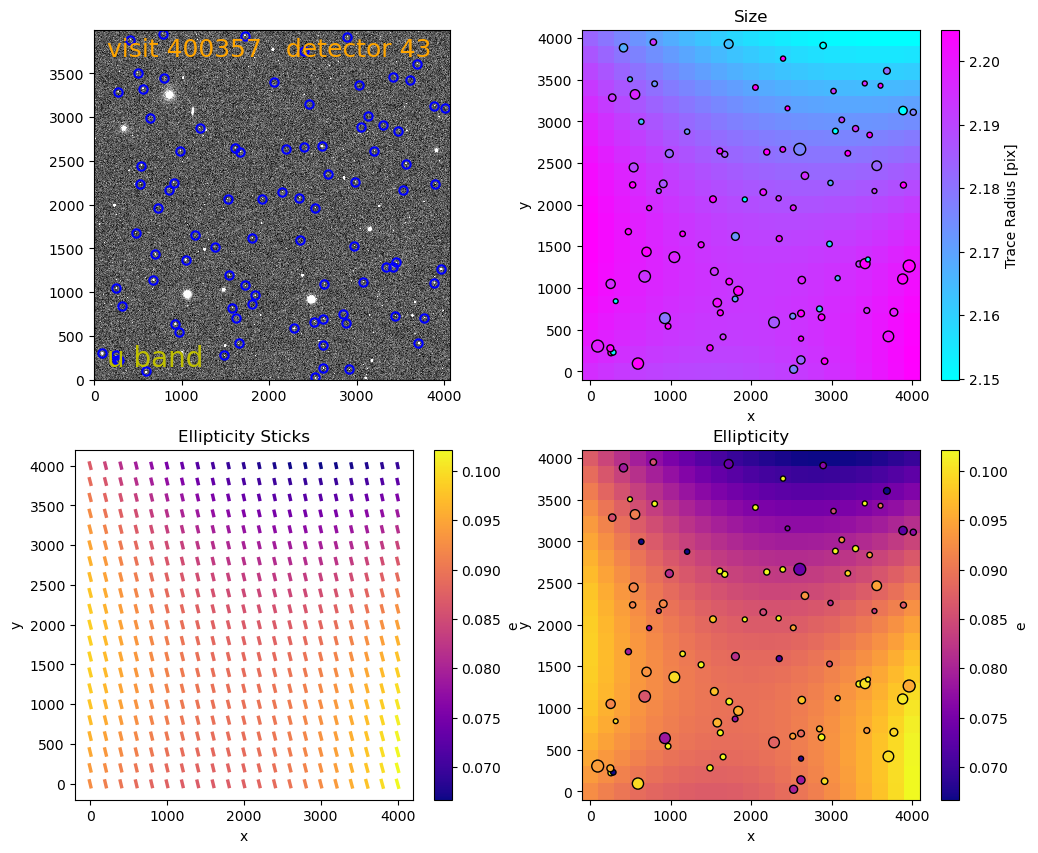

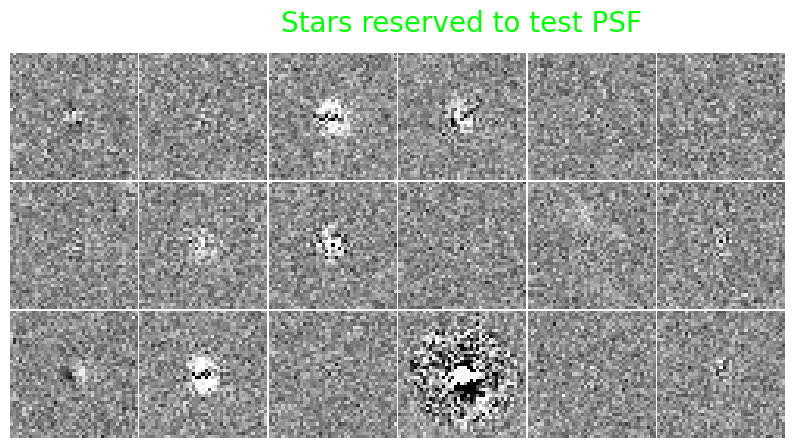

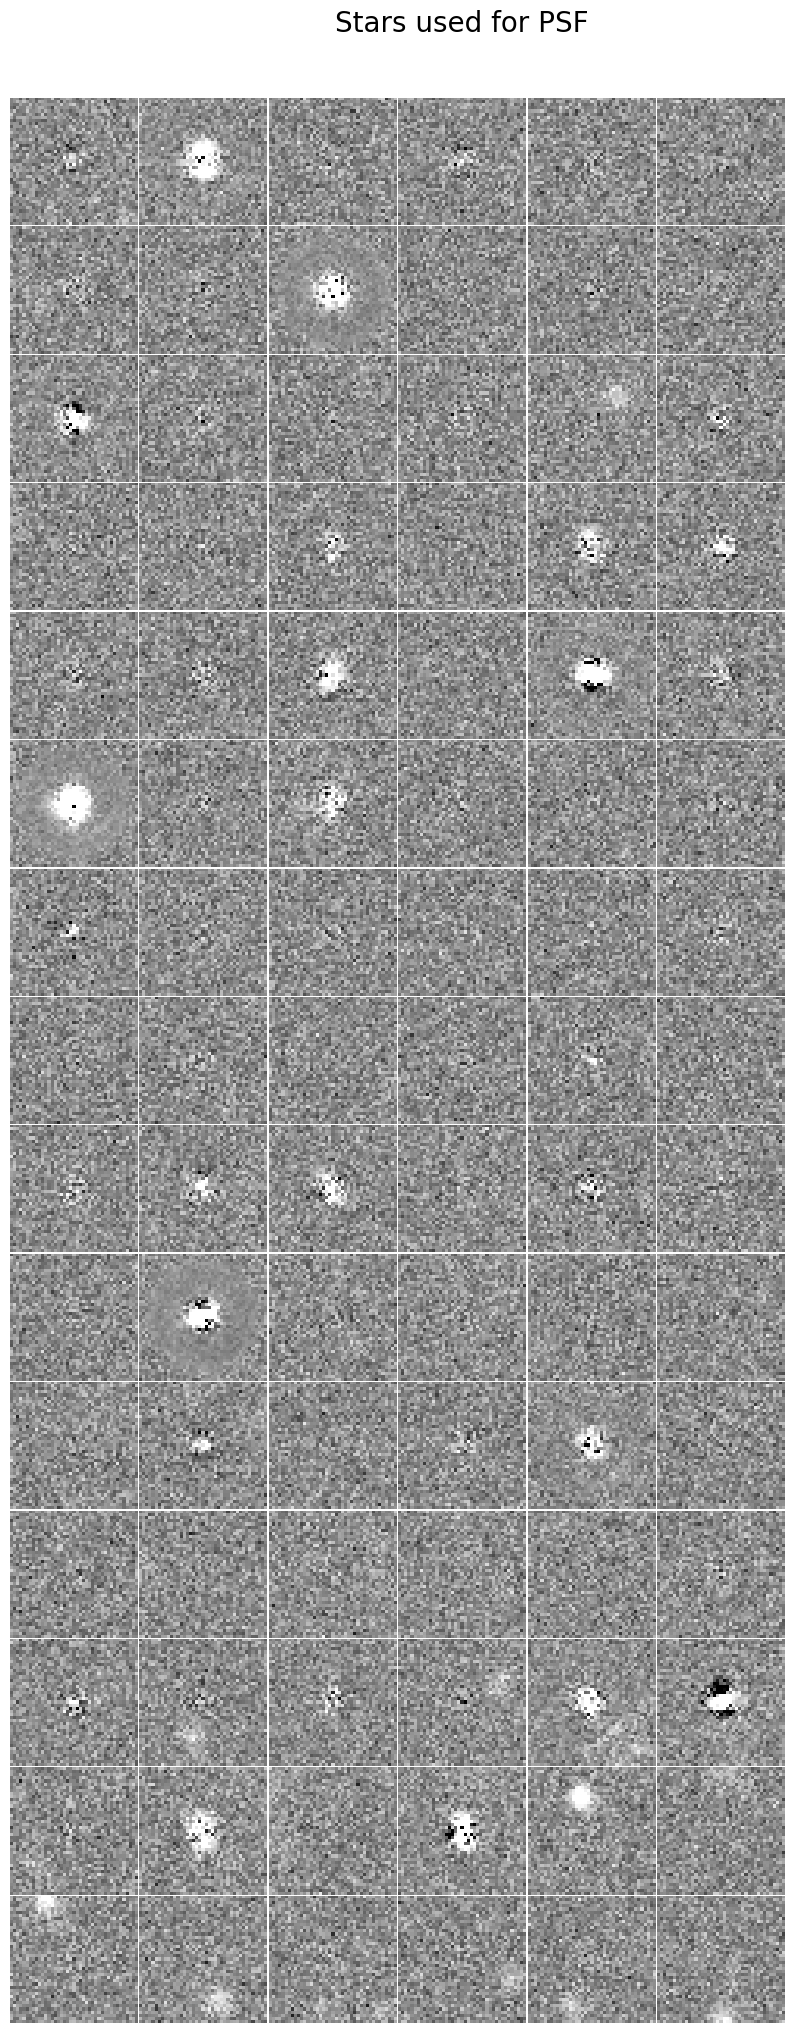

In [5]:
PSF_diagnostics(400357, 43, 'u')
plot_PSFresiduals(400357, 43, 'u')

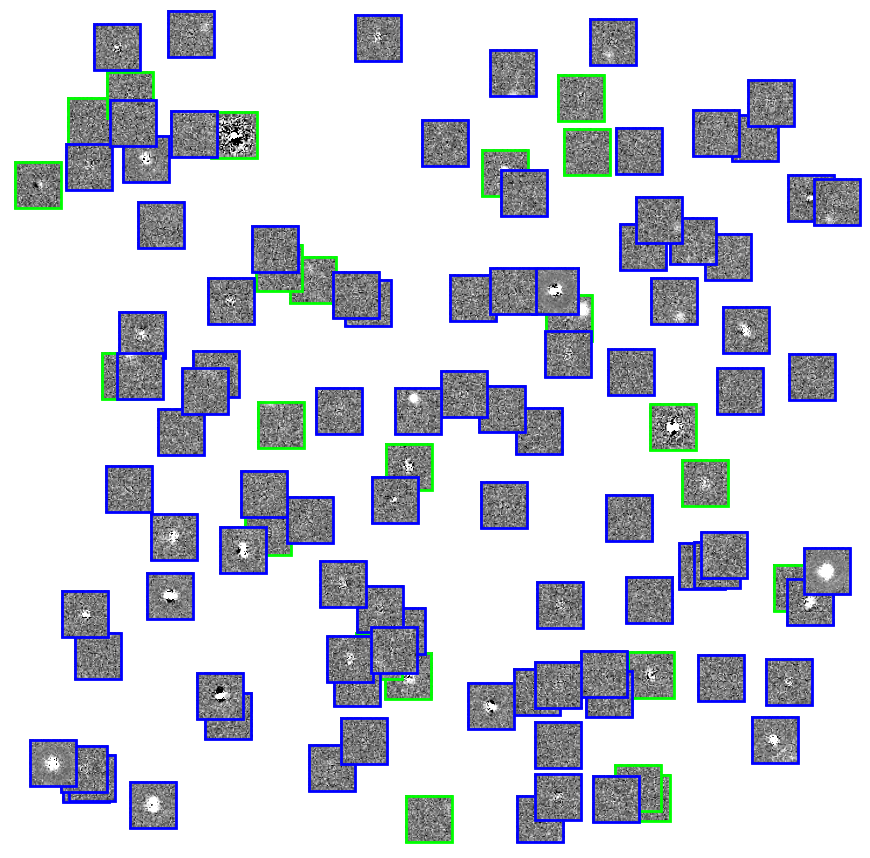

In [6]:
xdataId={'band':'u','visit':400357,'detector':43}  
xcalexp = butler.get('calexp', **xdataId)
xsrc = butler.get('src', **xdataId)

psf_used = xsrc[xsrc['calib_psf_used'] == True]
psf_reserved = xsrc[xsrc['calib_psf_reserved'] == True]
residuals = xcalexp.maskedImage.getImage()
psf = xcalexp.getPsf()

fig, ax = plt.subplots(frameon=False, figsize=(8,8))
ax = plt.Axes(fig, [0., 0., 1., 1.]) 
plt.axis('off')

for i in range(len(psf_reserved)):
    x_psfStar = psf_reserved[i]['base_SdssCentroid_x']/xcalexp.getDimensions()[0]
    y_psfStar = psf_reserved[i]['base_SdssCentroid_y']/xcalexp.getDimensions()[1]
    ax2 = fig.add_axes([x_psfStar, y_psfStar, 0.06, 0.06])
    psfImage = psf.computeImage(psf_reserved[i].getCentroid()).convertF()
    psfImage *= psf_reserved[i].getPsfInstFlux()/np.sum(psfImage.getArray())
    flux = psfImage.getArray() - residuals[psfImage.getBBox()].getArray()
    ax2.plot(20, 20, 's', mec='lime', mew=2, mfc='None', ms=33)
    ax2.imshow(flux, origin='lower', cmap = 'Greys', vmin=-120, vmax=80)
    ax2.set_axis_off()

for i in range(len(psf_used)):
    x_psfStar = psf_used[i]['base_SdssCentroid_x']/4000
    y_psfStar = psf_used[i]['base_SdssCentroid_y']/4000
    ax2 = fig.add_axes([x_psfStar, y_psfStar, 0.06, 0.06])
    psfImage = psf.computeImage(psf_used[i].getCentroid()).convertF()
    psfImage *= psf_used[i].getPsfInstFlux()/np.sum(psfImage.getArray())
    flux = psfImage.getArray() - residuals[psfImage.getBBox()].getArray()
    ax2.plot(20, 20, 's', mec='b', mew=2, mfc='None', ms=33)
    ax2.imshow(flux, origin='lower', cmap = 'Greys', vmin=-120, vmax=80)
    ax2.set_axis_off()


plt.subplots_adjust(left=0., right=1, bottom=0, top=1.)

## Full visit display -> get position for all the objects in the catalogue and extract PSF size at those coordinates. Different method to the grid of the calexp. 

In [7]:
def plot_FullVisit(visit,n_ccds):
    fig= plt.figure(figsize=(10,10))
    ax = plt.gca()

    output = []
    for det in range(n_ccds):
        xdataId = {'band':'u','visit':visit,'detector': det} 
        ccd = butler.get('calexp', **xdataId)
        src = butler.get('src', **xdataId)
    
        origin = ccd.getWcs().getPixelOrigin() #RA,DEC
        ccdBox = geom.Box2D(ccd.getBBox())
        corners_PIX = ccdBox.getCorners()
        corners_FP = [ccd.getDetector().transform(pixelPos, cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE) for pixelPos in corners_PIX]
        corners = [(c.getX()*100, c.getY()*100) for c in corners_FP]
        x_ccdShift = corners[0][0]
        y_ccdShift = corners[0][1]
        ################ PSF ################
        psf = ccd.getPsf()
        psf_used = src#[src['calib_psf_used'] == True]
    
        for i in range(len(psf_used)):
            point = psf_used[i].getCentroid()
            shape_psf = psf.computeShape(point)
            x_psf = point[0] + x_ccdShift
            y_psf = point[1] + y_ccdShift
            radius_psf = shape_psf.getTraceRadius()
            output.append([x_psf, y_psf, radius_psf])
        
    output = np.asarray(output)
    plt.rcParams['scatter.edgecolors'] = 'face'
    ax.scatter(output[:,0], output[:,1], c=output[:,2], s=10, cmap='cool', alpha=0.5)

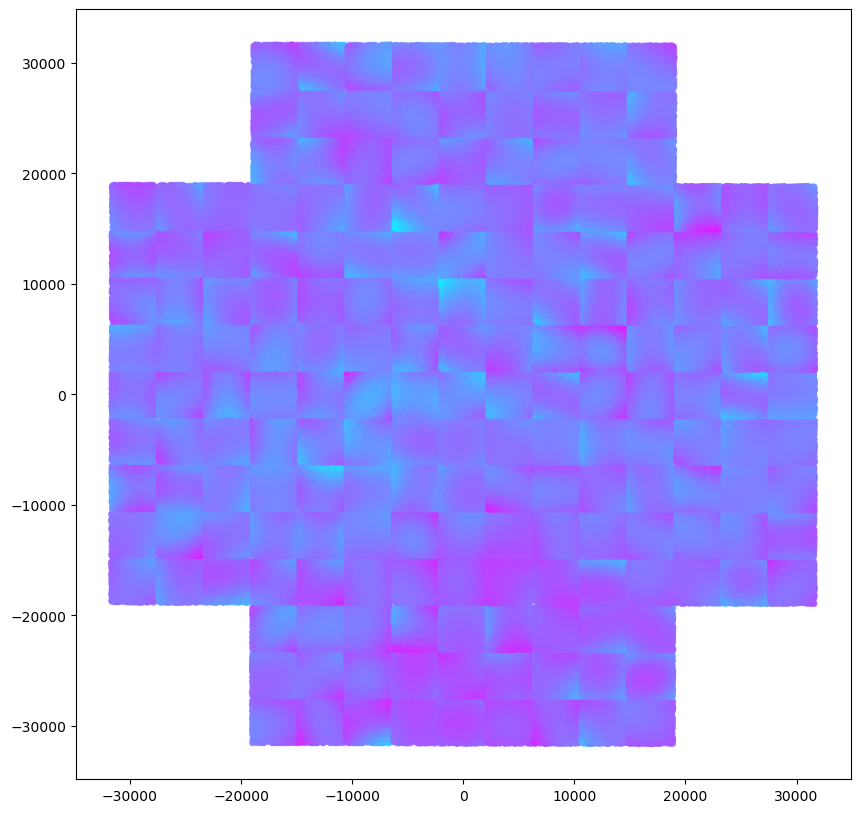

In [8]:
plot_FullVisit(400357,189)

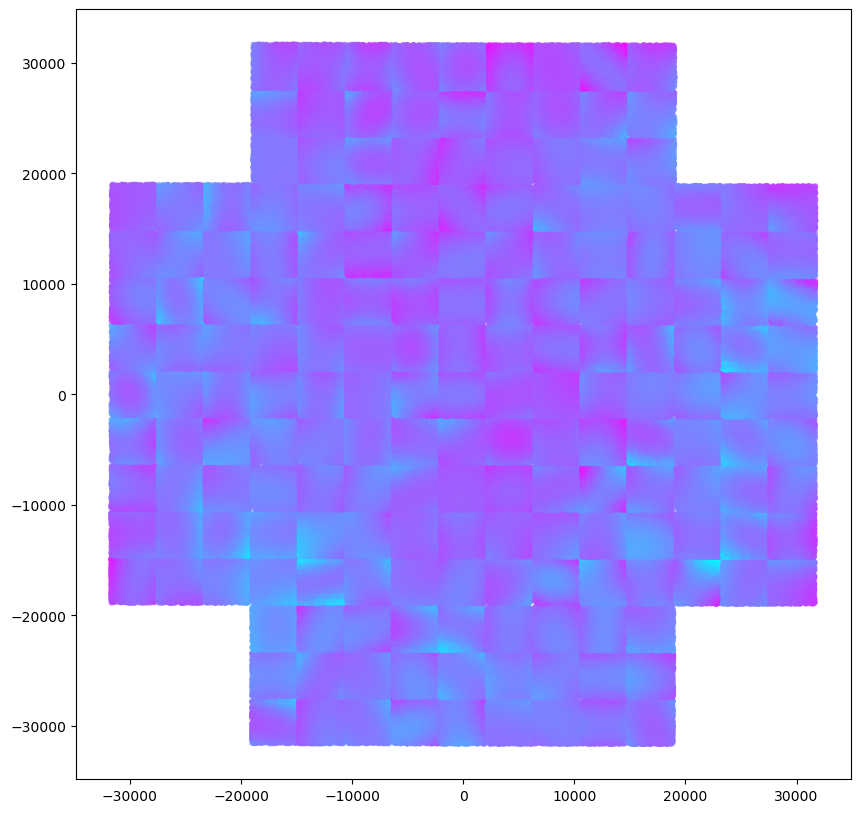

In [9]:
plot_FullVisit(159494,189) 

## Residuals. Jim Bosh suggestion:
histograms of delta(size), delta(e1), and delta(e2) 
(delta = PSF model - star, for each quantity)
Or perhaps scatter plots with those on the y axis and magnitude on the x axis.

In [10]:
def ellipticity_radii(i_xx, i_yy, i_xy):
        theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
        e1 = (i_xx - i_yy) / (i_xx + i_yy)
        e2 = (2. * i_xy) / (i_xx + i_yy)
        e = np.sqrt(e1**2 + e2**2)
        TraceRad = np.sqrt((i_xx + i_yy) / 2.)
        return TraceRad, e, e1, e2
    
def PSF_star_residuals_Visit(visit,n_ccds,nbins):
    
    output = []
    for det in range(n_ccds):
        xdataId = {'band':'u','visit':visit,'detector': det} 
        ccd = butler.get('calexp', **xdataId)
        src = butler.get('src', **xdataId)
        psf_used = src[src['calib_psf_used'] == True]
        
        for i in range(len(psf_used)):
            #ra = psf_used[i]['coord_ra']
            #dec = psf_used[i]['coord_dec']
            i_xx_sdss_psf = psf_used[i]['base_SdssShape_psf_xx']
            i_yy_sdss_psf = psf_used[i]['base_SdssShape_psf_yy']
            i_xy_sdss_psf = psf_used[i]['base_SdssShape_psf_xy']
            TraceRad_psf, e_psf, e1_psf, e2_psf = ellipticity_radii(i_xx_sdss_psf, i_yy_sdss_psf, i_xy_sdss_psf)
            i_xx_sdss_src = psf_used[i]['base_SdssShape_xx']
            i_yy_sdss_src = psf_used[i]['base_SdssShape_yy']
            i_xy_sdss_src = psf_used[i]['base_SdssShape_xy']
            TraceRad_star, e_star, e1_star, e2_star = ellipticity_radii(i_xx_sdss_src, i_yy_sdss_src, i_xy_sdss_src)
            output.append([TraceRad_psf, e_psf, e1_psf, e2_psf, TraceRad_star, e_star, e1_star, e2_star])
        
    output = np.asarray(output)
    delta_size = output[:,0] - output[:,4] #TraceRad_psf - TraceRad_star
    delta_e1 = output[:,2] - output[:,6] # e1_psf - e1_star
    delta_e2 = output[:,3] - output[:,7] #e2_psf - e2_star

    fig, ax = plt.subplots(1, 3, figsize=(11, 3))

    plt.sca(ax[0])  
    h_size = plt.hist(delta_size, nbins, color = 'b', alpha=0.4 )
    plt.xlabel(r'$\Delta_{size}$', fontsize=16)
    plt.ylabel('N')
    mean_delta_size = np.round(np.mean(delta_size),3)
    plt.axvline(x=mean_delta_size, color='k', ls='--', lw=2, alpha=0.4)
    plt.text(0.02, max(h_size[0])*0.9, str(mean_delta_size), color = 'k', fontsize=12)
    plt.xticks(ticks=[-0.04,-0.02, 0.0, 0.02, 0.04], labels=[-0.04,-0.02, 0.0, 0.02, 0.04])
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.sca(ax[1])  
    h_e1 = plt.hist(delta_e1, nbins, color = 'b', alpha=0.4)
    plt.xlabel(r'$\Delta_{e1}$', fontsize=16)
    #plt.ylabel('N')
    mean_delta_e1 = np.round(np.mean(delta_e1),3)
    plt.axvline(x=mean_delta_e1, color='k', ls='--', lw=2, alpha=0.4)
    plt.text(0.02, max(h_e1[0])*0.9, str(mean_delta_e1), color = 'k', fontsize=12)
    plt.xticks(ticks=[-0.04,-0.02, 0.0, 0.02, 0.04], labels=[-0.04,-0.02, 0.0, 0.02, 0.04])
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.sca(ax[2])  
    h_e2 = plt.hist(delta_e2, nbins, color = 'b', alpha=0.4)
    #print(max(h_e2[0]))
    plt.xlabel(r'$\Delta_{e2}$', fontsize=16)
    #plt.ylabel('N')
    mean_delta_e2 = np.round(np.mean(delta_e2),3)
    plt.axvline(x=mean_delta_e2, color='k', ls='--', lw=2, alpha=0.4)
    plt.text(0.02, max(h_e2[0])*0.9, str(mean_delta_e2), color = 'k', fontsize=12)

    plt.xticks(ticks=[-0.04,-0.02, 0.0, 0.02, 0.04], labels=[-0.04,-0.02, 0.0, 0.02, 0.04])
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)

    plt.subplots_adjust(wspace=0.25)



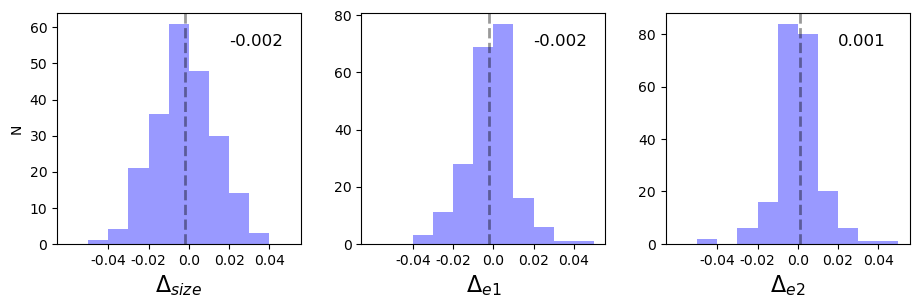

In [11]:
PSF_star_residuals_Visit(159494, 3, np.arange(-0.06, 0.06, 0.01))

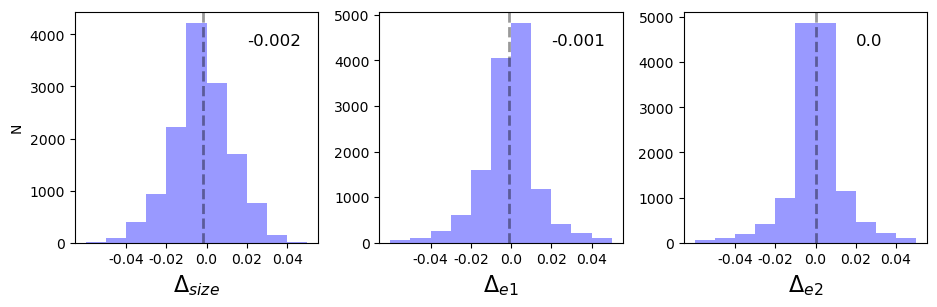

In [12]:
PSF_star_residuals_Visit(159494,189, np.arange(-0.06, 0.06, 0.01))

In [13]:

xxdataId = {'band':'u','visit':159494,'detector': 3} 
xccd = butler.get('calexp', **xxdataId)
xsrc = butler.get('src', **xxdataId)
#print(xsrc.getSchema().getNames())

#'base_CircularApertureFlux_12_0'


In [14]:
#r = xccd.getPhotoCalib().instFluxToMagnitudeArray(xsrc, 'base_CircularApertureFlux_17_0_instFlux')
psf_used = xsrc[xsrc['calib_psf_used'] == True]
for i in range(len(psf_used)):
    mag = -2.5*np.log10(psf_used[i]['base_CircularApertureFlux_17_0_instFlux'])


In [15]:
def PSF_star_residualsScatter_Visit(visit,n_ccds):
    
    output = []
    for det in range(n_ccds):
        xdataId = {'band':'u','visit':visit,'detector': det} 
        ccd = butler.get('calexp', **xdataId)
        src = butler.get('src', **xdataId)
        psf_used = src[src['calib_psf_used'] == True]
        
        for i in range(len(psf_used)):
            #ra = psf_used[i]['coord_ra']
            #dec = psf_used[i]['coord_dec']
            i_xx_sdss_psf = psf_used[i]['base_SdssShape_psf_xx']
            i_yy_sdss_psf = psf_used[i]['base_SdssShape_psf_yy']
            i_xy_sdss_psf = psf_used[i]['base_SdssShape_psf_xy']
            TraceRad_psf, e_psf, e1_psf, e2_psf = ellipticity_radii(i_xx_sdss_psf, i_yy_sdss_psf, i_xy_sdss_psf)
            i_xx_sdss_src = psf_used[i]['base_SdssShape_xx']
            i_yy_sdss_src = psf_used[i]['base_SdssShape_yy']
            i_xy_sdss_src = psf_used[i]['base_SdssShape_xy']
            TraceRad_star, e_star, e1_star, e2_star = ellipticity_radii(i_xx_sdss_src, i_yy_sdss_src, i_xy_sdss_src)
            mag = -2.5*np.log10(psf_used[i]['base_CircularApertureFlux_17_0_instFlux'])
            output.append([TraceRad_psf, e_psf, e1_psf, e2_psf, TraceRad_star, e_star, e1_star, e2_star, mag])
        
    output = np.asarray(output)
    delta_size = output[:,0] - output[:,4] #TraceRad_psf - TraceRad_star
    delta_e1 = output[:,2] - output[:,6] # e1_psf - e1_star
    delta_e2 = output[:,3] - output[:,7] #e2_psf - e2_star
    mag = output[:,8]
    fig, ax = plt.subplots(3, 1, figsize=(8, 8))

    plt.sca(ax[0]) 
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.3)
    plt.scatter(mag, delta_size, marker='.', color = 'b', alpha=0.2)
    plt.ylabel(r'$\Delta_{size}$',  fontsize=20)
    plt.ylim(-0.06, 0.06)
    plt.yticks(fontsize = 14)
    plt.yticks(ticks=[-0.05, -0.025, 0.0, 0.025, 0.05], labels=[-0.05, -0.025, 0.0, 0.025, 0.05])
    
    plt.sca(ax[1])
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.3)
    plt.scatter(mag, delta_e1, marker='.', color = 'b', alpha=0.2)
    plt.ylabel(r'$\Delta_{e1}$',  fontsize=20)
    plt.ylim(-0.1, 0.1)
    plt.xticks(fontsize = 14)
    plt.yticks(ticks=[-0.05, 0.0, 0.05], labels=[-0.05, 0.0, 0.05])
    plt.yticks(fontsize = 14) 

    
    plt.sca(ax[2])  
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.3)
    plt.scatter(mag, delta_e2, marker='.', color = 'b', alpha=0.2)
    plt.ylabel(r'$\Delta_{e2}$',  fontsize=20)
    plt.xlabel('magnitude', fontsize=18)
    plt.ylim(-0.08, 0.08)
    plt.xticks(fontsize = 14)
    plt.yticks(ticks=np.arange(-0.08, 0.08, 0.04), labels=[-0.08, -0.04, 0.0, 0.04])
    plt.yticks(fontsize = 14) 

    plt.subplots_adjust(hspace=0.0)

In [16]:
def PSF_star_residualsScatter_Visit(visit,n_ccds):
    
    output = []
    for det in range(n_ccds):
        xdataId = {'band':'u','visit':visit,'detector': det} 
        ccd = butler.get('calexp', **xdataId)
        src = butler.get('src', **xdataId)
        psf_used = src[src['calib_psf_used'] == True]
        
        for i in range(len(psf_used)):
            #ra = psf_used[i]['coord_ra']
            #dec = psf_used[i]['coord_dec']
            i_xx_sdss_psf = psf_used[i]['base_SdssShape_psf_xx']
            i_yy_sdss_psf = psf_used[i]['base_SdssShape_psf_yy']
            i_xy_sdss_psf = psf_used[i]['base_SdssShape_psf_xy']
            TraceRad_psf, e_psf, e1_psf, e2_psf = ellipticity_radii(i_xx_sdss_psf, i_yy_sdss_psf, i_xy_sdss_psf)
            i_xx_sdss_src = psf_used[i]['base_SdssShape_xx']
            i_yy_sdss_src = psf_used[i]['base_SdssShape_yy']
            i_xy_sdss_src = psf_used[i]['base_SdssShape_xy']
            TraceRad_star, e_star, e1_star, e2_star = ellipticity_radii(i_xx_sdss_src, i_yy_sdss_src, i_xy_sdss_src)
            mag = -2.5*np.log10(psf_used[i]['base_CircularApertureFlux_17_0_instFlux'])
            output.append([TraceRad_psf, e_psf, e1_psf, e2_psf, TraceRad_star, e_star, e1_star, e2_star, mag])

    output = np.asarray(output)

    df = pd.DataFrame({'TraceRad_psf': output[:,0], 'e_psf': output[:,1], 'e1_psf': output[:,2], 'e2_psf': output[:,3], 'TraceRad_star': output[:,4], 'e_star': output[:,5], 'e1_star': output[:,6], 'e2_star': output[:,7], 'mag': output[:,8]})
    #df = pd.DataFrame({'delta_size' : output[:,0] - output[:,4], 'mag' : mag}) 
    df['delta_size'] = df.TraceRad_psf - df.TraceRad_star #TraceRad_psf - TraceRad_star
    df['delta_e1'] = df.e1_psf - df.e1_star # e1_psf - e1_star
    df['delta_e2'] = df.e1_psf - df.e1_star #e2_psf - e2_star
    #mag = output[:,8]

    bins = np.linspace(df.mag.min(),df.mag.max(), 30)
    
    data_cut = pd.cut(df.mag,bins)           
    grp = df.groupby(by = data_cut)        
    ret = grp.aggregate(np.mean) 
    grp_mead = grp.aggregate(np.median)

    fig, ax = plt.subplots(3, 1, figsize=(8, 8))

    plt.sca(ax[0]) 
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.7)
    plt.scatter(df.mag, df.delta_size, marker='.', color = 'b', alpha=0.2)
    plt.plot(ret.mag, ret.delta_size,'r',lw=1,alpha=.7)
    plt.plot(grp_mead.mag, grp_mead.delta_size,'lime',lw=1,alpha=.7)
    #plt.scatter(mag, delta_size, marker='.', color = 'b', alpha=0.2)
    plt.ylabel(r'$\Delta_{size}$',  fontsize=20)
    plt.ylim(-0.06, 0.06)
    plt.yticks(fontsize = 14)
    plt.yticks(ticks=[-0.05, -0.025, 0.0, 0.025, 0.05], labels=[-0.05, -0.025, 0.0, 0.025, 0.05])
    
    plt.sca(ax[1])
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.7)
    plt.scatter(df.mag, df.delta_e1, marker='.', color = 'b', alpha=0.2)
    plt.plot(ret.mag, ret.delta_e1,'r',lw=1,alpha=.7)
    plt.ylabel(r'$\Delta_{e1}$',  fontsize=20)
    plt.ylim(-0.1, 0.1)
    plt.xticks(fontsize = 14)
    plt.yticks(ticks=[-0.05, 0.0, 0.05], labels=[-0.05, 0.0, 0.05])
    plt.yticks(fontsize = 14) 
    
    plt.sca(ax[2])  
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.7)
    plt.scatter(df.mag, df.delta_e2, marker='.', color = 'b', alpha=0.2)
    plt.plot(ret.mag, ret.delta_e2,'r',lw=1,alpha=.7)
    plt.ylabel(r'$\Delta_{e2}$',  fontsize=20)
    plt.xlabel('magnitude', fontsize=18)
    plt.ylim(-0.08, 0.08)
    plt.xticks(fontsize = 14)
    plt.yticks(ticks=np.arange(-0.08, 0.08, 0.04), labels=[-0.08, -0.04, 0.0, 0.04])
    plt.yticks(fontsize = 14) 
    plt.subplots_adjust(hspace=0.0)

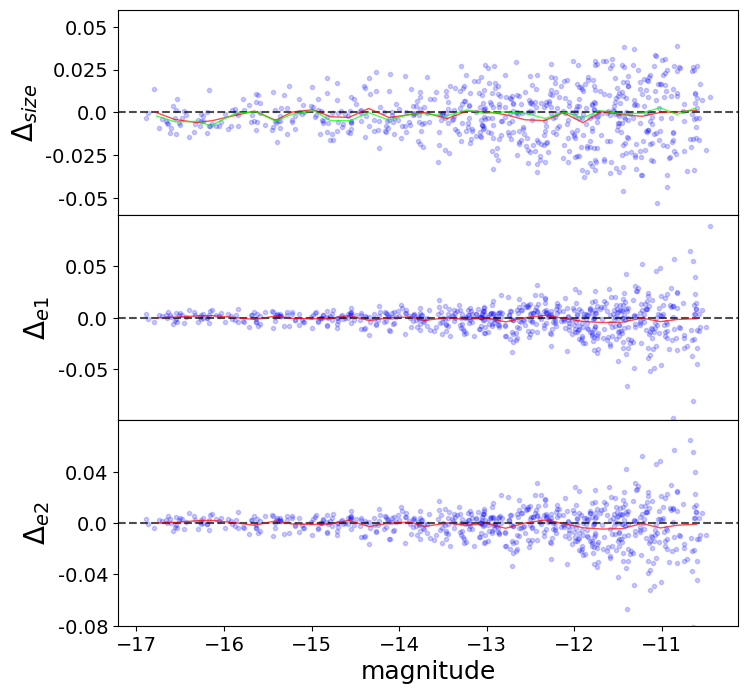

In [17]:
PSF_star_residualsScatter_Visit(159494,9)

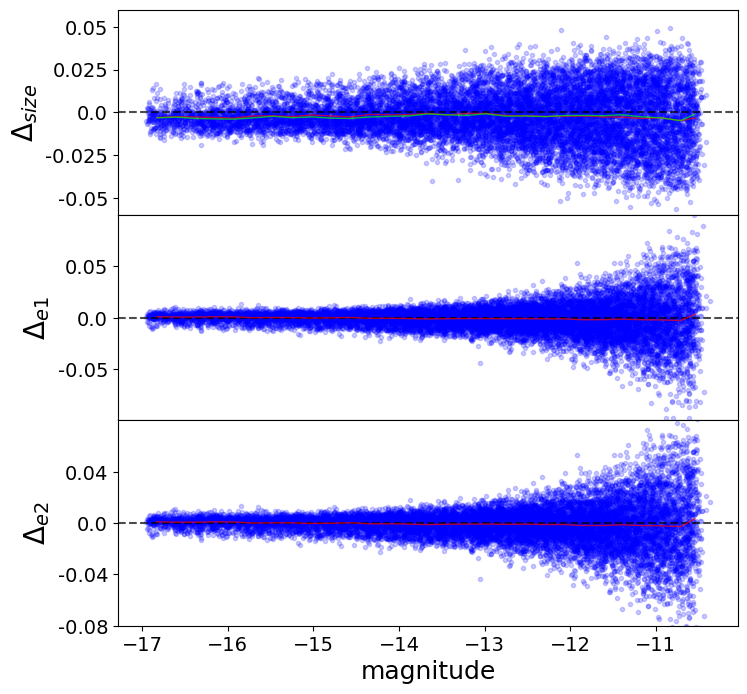

In [18]:
PSF_star_residualsScatter_Visit(159494,189)